# PyTorch and Image Loading

In [3]:
import torch


In [6]:
#torch version
torch.__version__


'2.5.1'

In [2]:
from PIL import Image
import numpy as np

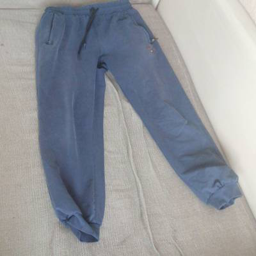

In [3]:
img = Image.open('clothing-dataset-small/train/pants/0098b991-e36e-4ef1-b5ee-4154b21e2a92.jpg')
img.resize((256, 256))

In [4]:
X = np.array(img.resize((224, 224)))

In [5]:
X

array([[[179, 181, 176],
        [179, 181, 176],
        [179, 181, 176],
        ...,
        [237, 230, 222],
        [238, 231, 223],
        [236, 229, 221]],

       [[180, 181, 176],
        [177, 178, 173],
        [177, 178, 173],
        ...,
        [237, 230, 222],
        [237, 230, 222],
        [235, 228, 220]],

       [[178, 179, 174],
        [175, 176, 171],
        [175, 176, 171],
        ...,
        [237, 230, 222],
        [237, 230, 222],
        [234, 227, 219]],

       ...,

       [[155, 149, 137],
        [155, 149, 137],
        [158, 152, 140],
        ...,
        [157, 149, 138],
        [159, 151, 140],
        [156, 148, 137]],

       [[151, 145, 133],
        [152, 146, 134],
        [157, 151, 139],
        ...,
        [155, 147, 136],
        [157, 149, 138],
        [155, 147, 136]],

       [[150, 144, 132],
        [152, 146, 134],
        [157, 151, 139],
        ...,
        [154, 146, 135],
        [155, 147, 136],
        [153, 145, 134]]

# Pre-trained Models

In [6]:
import torch
import torchvision.models as models
from torchvision import transforms
import numpy as np

# Load pre-trained model
model = models.mobilenet_v2(weights='IMAGENET1K_V1')
model.eval()

# Preprocessing for MobileNetV2
preprocess = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

Downloading: "https://download.pytorch.org/models/mobilenet_v2-b0353104.pth" to /Users/inigo_ocariz/.cache/torch/hub/checkpoints/mobilenet_v2-b0353104.pth
100.0%


In [7]:
img = Image.open('clothing-dataset-small/train/pants/0098b991-e36e-4ef1-b5ee-4154b21e2a92.jpg')
img_t = preprocess(img)
batch_t = torch.unsqueeze(img_t, 0)

# Make prediction
with torch.no_grad():
    output = model(batch_t)

# Get top predictions
_, indices = torch.sort(output, descending=True)

In [8]:
# Load ImageNet class names
with open("imagenet_classes.txt", "r") as f:
    categories = [s.strip() for s in f.readlines()]

# Get top 5 predictions
top5_indices = indices[0, :5].tolist()
top5_classes = [categories[i] for i in top5_indices]

print("Top 5 predictions:")
for i, class_name in enumerate(top5_classes):
    print(f"{i+1}: {class_name}")

Top 5 predictions:
1: jean
2: suit
3: cardigan
4: sweatshirt
5: overskirt


## Custom dataset class

In [9]:
import os
from torch.utils.data import Dataset
from PIL import Image

class ClothingDataset(Dataset):
    def __init__(self, data_dir, transform=None):
        self.data_dir = data_dir
        self.transform = transform
        self.image_paths = []
        self.labels = []
        self.classes = sorted(os.listdir(data_dir))
        self.class_to_idx = {cls: i for i, cls in enumerate(self.classes)}

        for label_name in self.classes:
            label_dir = os.path.join(data_dir, label_name)
            for img_name in os.listdir(label_dir):
                self.image_paths.append(os.path.join(label_dir, img_name))
                self.labels.append(self.class_to_idx[label_name])

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        img_path = self.image_paths[idx]
        image = Image.open(img_path).convert('RGB')
        label = self.labels[idx]

        if self.transform:
            image = self.transform(image)

        return image, label

## Simple preprocessing

In [10]:
from torchvision import transforms

input_size = 224

# ImageNet normalization values
mean = [0.485, 0.456, 0.406]
std = [0.229, 0.224, 0.225]

# Simple transforms - just resize and normalize
train_transforms = transforms.Compose([
    transforms.Resize((input_size, input_size)),
    transforms.ToTensor(),
    transforms.Normalize(mean=mean, std=std)
])

val_transforms = transforms.Compose([
    transforms.Resize((input_size, input_size)),
    transforms.ToTensor(),
    transforms.Normalize(mean=mean, std=std)
])

## Create DataLoaders

In [ ]:
from torch.utils.data import DataLoader

train_dataset = ClothingDataset(
    data_dir='./clothing-dataset-small/train',
    transform=train_transforms
)

val_dataset = ClothingDataset(
    data_dir='./clothing-dataset-small/validation',
    transform=val_transforms
)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)

# Build the Model

In [ ]:
import torch.nn as nn
import torchvision.models as models

class ClothingClassifierMobileNet(nn.Module):
    def __init__(self, num_classes=10):
        super(ClothingClassifierMobileNet, self).__init__()
        
        # Load pre-trained MobileNetV2
        self.base_model = models.mobilenet_v2(weights='IMAGENET1K_V1')
        
        # Freeze base model parameters
        for param in self.base_model.parameters():
            param.requires_grad = False
        
        # Remove original classifier
        self.base_model.classifier = nn.Identity()
        
        # Add custom layers
        self.global_avg_pooling = nn.AdaptiveAvgPool2d((1, 1))
        
        self.output_layer = nn.Linear(1280, num_classes)

    def forward(self, x):
        x = self.base_model.features(x)
        x = self.global_avg_pooling(x)
        x = torch.flatten(x, 1)
        x = self.output_layer(x)
        return x

# Train the model

In [16]:
import torch
import torch.optim as optim

if torch.backends.mps.is_available():
    device = torch.device("mps")
elif torch.cuda.is_available():
    device = torch.device("cuda")
else:
    device = torch.device("cpu")

print("Using device:", device)

model = ClothingClassifierMobileNet(num_classes=10)
model.to(device)

optimizer = optim.Adam(model.parameters(), lr=0.01)
criterion = nn.CrossEntropyLoss()

Using device: mps


In [17]:
# Training loop
num_epochs = 10

for epoch in range(num_epochs):
    # Training phase
    model.train()  # Set the model to training mode
    running_loss = 0.0
    correct = 0
    total = 0

    # Iterate over the training data
    for inputs, labels in train_loader:
        # Move data to the specified device (GPU or CPU)
        inputs, labels = inputs.to(device), labels.to(device)

        # Zero the parameter gradients to prevent accumulation
        optimizer.zero_grad()
        # Forward pass
        outputs = model(inputs)
        # Calculate the loss
        loss = criterion(outputs, labels)
        # Backward pass and optimize
        loss.backward()
        optimizer.step()

        # Accumulate training loss
        running_loss += loss.item()
        # Get predictions
        _, predicted = torch.max(outputs.data, 1)
        # Update total and correct predictions
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    # Calculate average training loss and accuracy
    train_loss = running_loss / len(train_loader)
    train_acc = correct / total

    # Validation phase
    model.eval()  # Set the model to evaluation mode
    val_loss = 0.0
    val_correct = 0
    val_total = 0

    # Disable gradient calculation for validation
    with torch.no_grad():
        # Iterate over the validation data
        for inputs, labels in val_loader:
            # Move data to the specified device (GPU or CPU)
            inputs, labels = inputs.to(device), labels.to(device)
            # Forward pass
            outputs = model(inputs)
            # Calculate the loss
            loss = criterion(outputs, labels)

            # Accumulate validation loss
            val_loss += loss.item()
            # Get predictions
            _, predicted = torch.max(outputs.data, 1)
            # Update total and correct predictions
            val_total += labels.size(0)
            val_correct += (predicted == labels).sum().item()

    # Calculate average validation loss and accuracy
    val_loss /= len(val_loader)
    val_acc = val_correct / val_total

    # Print epoch results
    print(f'Epoch {epoch+1}/{num_epochs}')
    print(f'  Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f}')
    print(f'  Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}')

Epoch 1/10
  Train Loss: 1.4354, Train Acc: 0.6307
  Val Loss: 0.8142, Val Acc: 0.7507
Epoch 2/10
  Train Loss: 0.7697, Train Acc: 0.7643
  Val Loss: 1.0605, Val Acc: 0.7126
Epoch 3/10
  Train Loss: 0.6832, Train Acc: 0.8005
  Val Loss: 0.9292, Val Acc: 0.7449
Epoch 4/10
  Train Loss: 0.6170, Train Acc: 0.8087
  Val Loss: 1.1166, Val Acc: 0.7302
Epoch 5/10
  Train Loss: 0.5475, Train Acc: 0.8383
  Val Loss: 0.8388, Val Acc: 0.7859
Epoch 6/10
  Train Loss: 0.5336, Train Acc: 0.8351
  Val Loss: 0.9315, Val Acc: 0.7742
Epoch 7/10
  Train Loss: 0.5651, Train Acc: 0.8364
  Val Loss: 0.9937, Val Acc: 0.7595
Epoch 8/10
  Train Loss: 0.4939, Train Acc: 0.8530
  Val Loss: 1.3935, Val Acc: 0.7654
Epoch 9/10
  Train Loss: 0.5188, Train Acc: 0.8579
  Val Loss: 1.7933, Val Acc: 0.6921
Epoch 10/10
  Train Loss: 0.6074, Train Acc: 0.8422
  Val Loss: 1.1686, Val Acc: 0.7742


In [ ]:
def train_and_evaluate(model, optimizer, train_loader, val_loader, criterion, num_epochs, device):
    
    for epoch in range(num_epochs):
        # Training phase
        model.train()
        running_loss = 0.0
        correct = 0
        total = 0

        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)

            total += labels.size(0)
            correct += (predicted == labels).sum().item()

        train_loss = running_loss / len(train_loader)
        train_acc = correct / total

        # Validation phase
        model.eval()
        val_loss = 0.0
        val_correct = 0
        val_total = 0

        with torch.no_grad():
            for inputs, labels in val_loader:
                inputs, labels = inputs.to(device), labels.to(device)

                outputs = model(inputs)
                loss = criterion(outputs, labels)

                val_loss += loss.item()
                _, predicted = torch.max(outputs.data, 1)
                val_total += labels.size(0)
                val_correct += (predicted == labels).sum().item()

        val_loss /= len(val_loader)
        val_acc = val_correct / val_total

        print(f'Epoch {epoch+1}/{num_epochs}')
        print(f'  Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f}')
        print(f'  Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}')

# Tuning the learning rate

In [18]:
def make_model(learning_rate=0.01):
    model = ClothingClassifierMobileNet(num_classes=10)
    model.to(device)
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)
    return model, optimizer

In [21]:
learning_rates = [0.0001, 0.001, 0.01, 0.1]

for lr in learning_rates:
    print(f'\n=== Learning Rate: {lr} ===')
    model, optimizer = make_model(learning_rate=lr)
    train_and_evaluate(model, optimizer, train_loader, val_loader, criterion, num_epochs, device)


=== Learning Rate: 0.0001 ===
Epoch 1/10
  Train Loss: 2.0113, Train Acc: 0.2862
  Val Loss: 1.7643, Val Acc: 0.4047
Epoch 2/10
  Train Loss: 1.6427, Train Acc: 0.4863
  Val Loss: 1.4868, Val Acc: 0.5396
Epoch 3/10
  Train Loss: 1.4024, Train Acc: 0.5779
  Val Loss: 1.2862, Val Acc: 0.6158
Epoch 4/10
  Train Loss: 1.2417, Train Acc: 0.6415
  Val Loss: 1.1475, Val Acc: 0.6569
Epoch 5/10
  Train Loss: 1.1254, Train Acc: 0.6864
  Val Loss: 1.0569, Val Acc: 0.6716
Epoch 6/10
  Train Loss: 1.0303, Train Acc: 0.7154
  Val Loss: 0.9835, Val Acc: 0.6979
Epoch 7/10
  Train Loss: 0.9658, Train Acc: 0.7389
  Val Loss: 0.9216, Val Acc: 0.7273
Epoch 8/10
  Train Loss: 0.9098, Train Acc: 0.7510
  Val Loss: 0.8907, Val Acc: 0.7537
Epoch 9/10
  Train Loss: 0.8671, Train Acc: 0.7669
  Val Loss: 0.8398, Val Acc: 0.7625
Epoch 10/10
  Train Loss: 0.8242, Train Acc: 0.7748
  Val Loss: 0.8175, Val Acc: 0.7801

=== Learning Rate: 0.001 ===
Epoch 1/10
  Train Loss: 1.2649, Train Acc: 0.5968
  Val Loss: 0.815

## Adding inner layers

In [ ]:
class ClothingClassifierMobileNet(nn.Module):
    def __init__(self, size_inner=100, num_classes=10):
        super(ClothingClassifierMobileNet, self).__init__()
        
        self.base_model = models.mobilenet_v2(weights='IMAGENET1K_V1')
        
        for param in self.base_model.parameters():
            param.requires_grad = False
        
        self.base_model.classifier = nn.Identity()
        
        self.global_avg_pooling = nn.AdaptiveAvgPool2d((1, 1))
        
        self.inner = nn.Linear(1280, size_inner)  # New inner layer
        self.relu = nn.ReLU()
        self.output_layer = nn.Linear(size_inner, num_classes)

    def forward(self, x):
        x = self.base_model.features(x)
        x = self.global_avg_pooling(x)
        x = torch.flatten(x, 1)
        x = self.inner(x)
        x = self.relu(x)
        x = self.output_layer(x)
        return x

In [29]:
def make_model(learning_rate=0.001, size_inner=100):
    model = ClothingClassifierMobileNet(
        num_classes=10,
        size_inner=size_inner
    )
    model.to(device)
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)
    return model, optimizer

In [31]:
size_inners = [10, 100, 1000]

for size_inner in size_inners:
    print(f'\n=== Size Inner: {size_inner} ===')
    model, optimizer = make_model(learning_rate= 0.001, size_inner=size_inner)
    train_and_evaluate(model, optimizer, train_loader, val_loader, criterion, num_epochs, device)


=== Size Inner: 10 ===
Epoch 1/10
  Train Loss: 1.7496, Train Acc: 0.4589
  Val Loss: 1.3823, Val Acc: 0.5543
Epoch 2/10
  Train Loss: 1.2671, Train Acc: 0.6030
  Val Loss: 1.1423, Val Acc: 0.6129
Epoch 3/10
  Train Loss: 1.0510, Train Acc: 0.6640
  Val Loss: 1.0061, Val Acc: 0.6510
Epoch 4/10
  Train Loss: 0.9575, Train Acc: 0.6874
  Val Loss: 0.8991, Val Acc: 0.7038
Epoch 5/10
  Train Loss: 0.8710, Train Acc: 0.7053
  Val Loss: 0.8352, Val Acc: 0.7126
Epoch 6/10
  Train Loss: 0.7747, Train Acc: 0.7461
  Val Loss: 0.8044, Val Acc: 0.7126
Epoch 7/10
  Train Loss: 0.7244, Train Acc: 0.7715
  Val Loss: 0.7693, Val Acc: 0.7478
Epoch 8/10
  Train Loss: 0.6954, Train Acc: 0.7705
  Val Loss: 0.7555, Val Acc: 0.7595
Epoch 9/10
  Train Loss: 0.6724, Train Acc: 0.7829
  Val Loss: 0.7213, Val Acc: 0.7625
Epoch 10/10
  Train Loss: 0.6316, Train Acc: 0.7914
  Val Loss: 0.7060, Val Acc: 0.7449

=== Size Inner: 100 ===
Epoch 1/10
  Train Loss: 1.2756, Train Acc: 0.5779
  Val Loss: 0.7979, Val Acc: 

# Add checkpoint

In [32]:
def train_and_evaluate(model, optimizer, train_loader, val_loader, criterion, num_epochs, device):
    best_val_accuracy = 0.0  # Initialize variable to track the best validation accuracy
    for epoch in range(num_epochs):
        # Training phase
        model.train()
        running_loss = 0.0
        correct = 0
        total = 0

        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)

            total += labels.size(0)
            correct += (predicted == labels).sum().item()

        train_loss = running_loss / len(train_loader)
        train_acc = correct / total

        # Validation phase
        model.eval()
        val_loss = 0.0
        val_correct = 0
        val_total = 0

        with torch.no_grad():
            for inputs, labels in val_loader:
                inputs, labels = inputs.to(device), labels.to(device)

                outputs = model(inputs)
                loss = criterion(outputs, labels)

                val_loss += loss.item()
                _, predicted = torch.max(outputs.data, 1)
                val_total += labels.size(0)
                val_correct += (predicted == labels).sum().item()

        val_loss /= len(val_loader)
        val_acc = val_correct / val_total


        print(f'Epoch {epoch+1}/{num_epochs}')
        print(f'  Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f}')
        print(f'  Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}')

        # exising code
        # Checkpoint the model if validation accuracy improved
        if val_acc > best_val_accuracy:
            best_val_accuracy = val_acc
            checkpoint_path = f'mobilenet_v2_{epoch+1:02d}_{val_acc:.3f}.pth'
            torch.save(model.state_dict(), checkpoint_path)
            print(f'Checkpoint saved: {checkpoint_path}')

In [33]:
class ClothingClassifierMobileNet(nn.Module):
    def __init__(self, size_inner=100, num_classes=10):
        super(ClothingClassifierMobileNet, self).__init__()
        
        self.base_model = models.mobilenet_v2(weights='IMAGENET1K_V1')
        
        for param in self.base_model.parameters():
            param.requires_grad = False
        
        self.base_model.classifier = nn.Identity()
        
        self.global_avg_pooling = nn.AdaptiveAvgPool2d((1, 1))
        
        self.inner = nn.Linear(1280, size_inner)  # New inner layer
        self.relu = nn.ReLU()
        self.output_layer = nn.Linear(size_inner, num_classes)

    def forward(self, x):
        x = self.base_model.features(x)
        x = self.global_avg_pooling(x)
        x = torch.flatten(x, 1)
        x = self.inner(x)
        x = self.relu(x)
        x = self.output_layer(x)
        return x

In [34]:
def make_model(learning_rate=0.001, size_inner=100):
    model = ClothingClassifierMobileNet(
        num_classes=10,
        size_inner=size_inner
    )
    model.to(device)
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)
    return model, optimizer

In [35]:
size_inners = 100
learning_rate = 0.001

model, optimizer = make_model(learning_rate=learning_rate, size_inner=size_inners)
train_and_evaluate(model, optimizer, train_loader, val_loader, criterion, num_epochs, device)


Epoch 1/10
  Train Loss: 1.2358, Train Acc: 0.6105
  Val Loss: 0.8032, Val Acc: 0.7361
Checkpoint saved: mobilenet_v2_01_0.736.pth
Epoch 2/10
  Train Loss: 0.6923, Train Acc: 0.7797
  Val Loss: 0.6828, Val Acc: 0.7713
Checkpoint saved: mobilenet_v2_02_0.771.pth
Epoch 3/10
  Train Loss: 0.5696, Train Acc: 0.8077
  Val Loss: 0.6542, Val Acc: 0.7830
Checkpoint saved: mobilenet_v2_03_0.783.pth
Epoch 4/10
  Train Loss: 0.5281, Train Acc: 0.8149
  Val Loss: 0.6227, Val Acc: 0.7801
Epoch 5/10
  Train Loss: 0.4470, Train Acc: 0.8504
  Val Loss: 0.5779, Val Acc: 0.7977
Checkpoint saved: mobilenet_v2_05_0.798.pth
Epoch 6/10
  Train Loss: 0.4326, Train Acc: 0.8563
  Val Loss: 0.5702, Val Acc: 0.8006
Checkpoint saved: mobilenet_v2_06_0.801.pth
Epoch 7/10
  Train Loss: 0.4012, Train Acc: 0.8615
  Val Loss: 0.5548, Val Acc: 0.8035
Checkpoint saved: mobilenet_v2_07_0.804.pth
Epoch 8/10
  Train Loss: 0.3730, Train Acc: 0.8726
  Val Loss: 0.5924, Val Acc: 0.8123
Checkpoint saved: mobilenet_v2_08_0.812.

# Dropout

In [36]:
class ClothingClassifierMobileNet(nn.Module):
    def __init__(self, size_inner=100, droprate=0.2, num_classes=10):
        super(ClothingClassifierMobileNet, self).__init__()
        
        self.base_model = models.mobilenet_v2(weights='IMAGENET1K_V1')
        
        for param in self.base_model.parameters():
            param.requires_grad = False
        
        self.base_model.classifier = nn.Identity()
        
        self.global_avg_pooling = nn.AdaptiveAvgPool2d((1, 1))
        self.inner = nn.Linear(1280, size_inner)
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(droprate)  # Add dropout
        self.output_layer = nn.Linear(size_inner, num_classes)

    def forward(self, x):
        x = self.base_model.features(x)
        x = self.global_avg_pooling(x)
        x = torch.flatten(x, 1)
        x = self.inner(x)
        x = self.relu(x)
        x = self.dropout(x)  # Apply dropout
        x = self.output_layer(x)
        return x

In [37]:
def make_model(
        learning_rate=0.001,
        size_inner=100,
        droprate=0.2
):
    model = ClothingClassifierMobileNet(
        num_classes=10,
        size_inner=size_inner,
        droprate=droprate
    )
    model.to(device)
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)
    return model, optimizer

In [41]:
dropout_rate = [0.0, 0.2, 0.5, 0.8]
num_epochs = 50

for drop_rate in dropout_rate:
    print(f'\n=== Dropout Rate: {drop_rate} ===')
    model, optimizer = make_model(
        learning_rate=0.001,
        size_inner=100,
        droprate=drop_rate
    )
    train_and_evaluate(model, optimizer, train_loader, val_loader, criterion, num_epochs, device)


=== Dropout Rate: 0.0 ===


KeyboardInterrupt: 

# Data Augmentation

In [42]:
from torchvision import transforms

input_size = 224

# ImageNet normalization values
mean = [0.485, 0.456, 0.406]
std = [0.229, 0.224, 0.225]

# Training transforms WITH augmentation
train_transforms = transforms.Compose([
    transforms.RandomRotation(10),           # Rotate up to 10 degrees
    transforms.RandomResizedCrop(224, scale=(0.9, 1.0)),  # Zoom
    transforms.RandomHorizontalFlip(),       # Horizontal flip
    transforms.ToTensor(),
    transforms.Normalize(mean=mean, std=std)
])

# Validation transforms - NO augmentation, same as before
val_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=mean, std=std)
])

In [44]:
model, optimizer = make_model(
    learning_rate=0.001,
    size_inner=100,
    droprate=0.5
  )

train_and_evaluate(model, optimizer, train_loader, val_loader, criterion, num_epochs, device)

Epoch 1/50
  Train Loss: 1.5387, Train Acc: 0.4892
  Val Loss: 1.0118, Val Acc: 0.6891
Checkpoint saved: mobilenet_v2_01_0.689.pth
Epoch 2/50
  Train Loss: 1.0412, Train Acc: 0.6538
  Val Loss: 0.8546, Val Acc: 0.7126
Checkpoint saved: mobilenet_v2_02_0.713.pth
Epoch 3/50
  Train Loss: 0.8902, Train Acc: 0.7024
  Val Loss: 0.6985, Val Acc: 0.7771
Checkpoint saved: mobilenet_v2_03_0.777.pth
Epoch 4/50
  Train Loss: 0.7830, Train Acc: 0.7301
  Val Loss: 0.6235, Val Acc: 0.7625
Epoch 5/50
  Train Loss: 0.7439, Train Acc: 0.7487
  Val Loss: 0.6772, Val Acc: 0.7507
Epoch 6/50
  Train Loss: 0.7071, Train Acc: 0.7552
  Val Loss: 0.5898, Val Acc: 0.7977
Checkpoint saved: mobilenet_v2_06_0.798.pth
Epoch 7/50
  Train Loss: 0.6826, Train Acc: 0.7679
  Val Loss: 0.5668, Val Acc: 0.8094
Checkpoint saved: mobilenet_v2_07_0.809.pth
Epoch 8/50
  Train Loss: 0.6169, Train Acc: 0.7859
  Val Loss: 0.5541, Val Acc: 0.7918
Epoch 9/50
  Train Loss: 0.6197, Train Acc: 0.7888
  Val Loss: 0.5696, Val Acc: 0.80

KeyboardInterrupt: 

# Load model

In [45]:
path = 'mobilenet_v2_21_0.830.pth'

In [46]:
path = 'mobilenet_v2_21_0.830.pth'
model = ClothingClassifierMobileNet(size_inner=100, droprate=0.2, num_classes=10)
model.load_state_dict(torch.load(path))
model.to(device)
model.eval();

/var/folders/dz/5wmz844x1q782bmfw947xv2h0000gn/T/ipykernel_75806/279796882.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(path))


In [47]:
x = val_transforms(img)
batch_t = torch.unsqueeze(x, 0).to(device)

with torch.no_grad():
    output = model(batch_t)

In [49]:
classes = ['dress',
 'hat',
 'longsleeve',
 'outwear',
 'pants',
 'shirt',
 'shoes',
 'shorts',
 'skirt',
 't-shirt']

In [50]:
dict(zip(classes, output[0].to('cpu')))

{'dress': tensor(-2.2166),
 'hat': tensor(-5.4738),
 'longsleeve': tensor(0.9914),
 'outwear': tensor(-2.7001),
 'pants': tensor(7.1855),
 'shirt': tensor(-1.5142),
 'shoes': tensor(-4.2473),
 'shorts': tensor(-1.2894),
 'skirt': tensor(-3.3992),
 't-shirt': tensor(-6.9841)}

In [ ]:
dummy_input = torch.randn(1, 3, 224, 224).to(device)

# Export to ONNX
onnx_path = "clothing_classifier_mobilenet_v2.onnx"

torch.onnx.export(
    model,
    dummy_input,
    onnx_path,
    verbose=True,
    input_names=['input'],
    output_names=['output'],
    dynamic_axes={
        'input': {0: 'batch_size'},
        'output': {0: 'batch_size'}
    }
)